# Intergrated Gradients of the nl-BERT-large Model Post Fine-tuning
In this notebook we:

1. Employ the best performing fine-tuned model identified in the `nbl_Finetune_opt_param.ipynb`.
2. extract Intergrated Gradients (IG) values for the model to note which features (here tokens) contributes to the classification of either "female" or "male" artists in the post-fine-tuning state of the nl-BERT-large model.

The output os this can then be compared to those of the model prior to fine-tuning in the `IG_DIFFERENTIALS.ipynb`.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#### Install packages:
!pip install -q transformers transformers-interpret datasets evaluate tensorflow spacy spacy_langdetect shap matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 998.1/998.1 kB 56.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.5 MB/s eta 0:00:00


In [ ]:
### Importing packages:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np

### Loading model and tokenizer
Here we load the model fitted in the `nbl_Finetune_opt_param.ipynb` notebook (checkpoint-174), as this was the best performing model on the validation set. The tokenizer remains the same.

In [ ]:
# Path to your checkpoint directory
checkpoint_path = "/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/models/checkpoint-174"

# Load the fine-tuned model weights
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

# Load the tokenizer from the original pre-trained model
original_model = "NbAiLab/nb-bert-large"
tokenizer = AutoTokenizer.from_pretrained(original_model)

tokenizer_config.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/395k [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/eval_outputs/NBL_df_classification_report.csv')
texts = df['Text'].tolist() # extracting all texts to a list

In [ ]:
!pip install -q shap transformers-interpret

In [ ]:
from transformers_interpret import SequenceClassificationExplainer

# Creating a sequence classification explainer
explainer = SequenceClassificationExplainer(
    model=model,
    tokenizer=tokenizer
)

# Getting IG values 5 batches at a time
This is done due to limited GPU capacity. Everything beyond 5 batches, crashes the run.
Thus, the explainer function is used continously at each 5 batch and the output saved for each round.

In [ ]:
import os
import json

# Function to divide texts into batches
def batchify(texts, batch_size):
    return [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]

# Define batch size and divide texts into batches
batch_size = 5  # this is adjusted to match memory capacity
text_batches = batchify(texts, batch_size)

# File to track processed batches
processed_batches_file = '/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/IG/ig_outputs_finetuned/processed_batches.txt'

# Function to save IG values
def save_shap_values(batch_index, shap_values):
    with open(f'/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/IG/ig_outputs_finetuned/shap_values_batch_{batch_index}.json', 'w') as f:
        json.dump(shap_values, f)

# Function to get the last processed batch index
def get_last_processed_batch():
    if os.path.exists(processed_batches_file):
        with open(processed_batches_file, 'r') as f:
            return int(f.read().strip())
    return 0

In [ ]:
# Start processing from the next batch after the last processed batch
last_processed_batch = get_last_processed_batch()

for batch_index, batch in enumerate(text_batches):
    if batch_index <= last_processed_batch:
        continue

    # Process batch
    batch_shap_values = [explainer(text) for text in batch]

    # Save IG values
    save_shap_values(batch_index, batch_shap_values)

    # Update processed batches file
    with open(processed_batches_file, 'w') as f:
        f.write(str(batch_index))

    # Clear memory if needed
    del batch_shap_values
    torch.cuda.empty_cache()

In [ ]:
#### we missed the first 5 texts (batch 0). Due to memory limitations we can't run it all over again..
#### so we'll run the shap for the first 5:
text0 = df['Text'][0:5].tolist()
batch_shap_values = [explainer(text) for text in text0]
save_shap_values(0, batch_shap_values)

### Identifying the most 'informative' features across all classifications

---



In [ ]:
### lets load the shap values back in:
import pandas as pd
import json
from pathlib import Path

def load_json_to_dataframe(directory_path):
    # List all .json files in the directory
    json_files = Path(directory_path).glob('*.json')

    # Create an empty DataFrame with columns for tokens and values
    df = pd.DataFrame(columns=['token', 'value'])

    # Function to flatten JSON content
    def flatten_json(json_content):
        return [pair for sublist in json_content for pair in sublist]

    # Loop through all .json files and append their content to the DataFrame
    for json_file in json_files:
        # Open and load the json file
        with open(json_file, 'r') as file:
            json_content = json.load(file)

        # Flattening the JSON content
        flattened_data = flatten_json(json_content)
        temp_df = pd.DataFrame(flattened_data, columns=['token', 'value'])

        # Append to the main DataFrame
        df = df.append(temp_df, ignore_index=True)

    return df


df_tokens = load_json_to_dataframe('/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/IG/IG_outputs_finetuned')


### Averaging duplicates:

In [19]:
def average_duplicates_with_count(df):
    # Categorize each row as 'negative' or 'positive' based on the 'value'
    df['category'] = df['value'].apply(lambda x: 'negative' if x < 0 else 'positive')
    # Group by 'token' and 'category', calculate the mean of 'value' and count the occurrences
    df_avg = df.groupby(['token', 'category']).agg(
        value=('value', 'mean'),
        n=('token', 'count')
    ).reset_index()

    return df_avg


df_no_duplicates = average_duplicates_with_count(df_tokens)
df_no_duplicates

,token,category,value,n
0,!,negative,-0.012553,50
1,!,positive,0.005824,58
2,"""",negative,-0.029269,2
3,##0,negative,-0.001411,3
4,##0,positive,0.002073,2
...,...,...,...,...
16632,øvet,positive,0.015020,4
16633,øvrig,negative,-0.001831,2
16634,øvrig,positive,0.005879,9
16635,øvrige,negative,-0.006699,1


lets get the 40 most 'informative' words:

In [ ]:
# Sorting the DataFrame by 'value' in descending order and take the top 40
df_top25 = df_no_duplicates.sort_values(by='value', ascending=False).head(20)
df_low25 = df_no_duplicates.sort_values(by='value', ascending=True).head(20)
df_low25_upside = df_low25.sort_values(by='value', ascending=False).head(20)


In [ ]:
import matplotlib.pyplot as plt

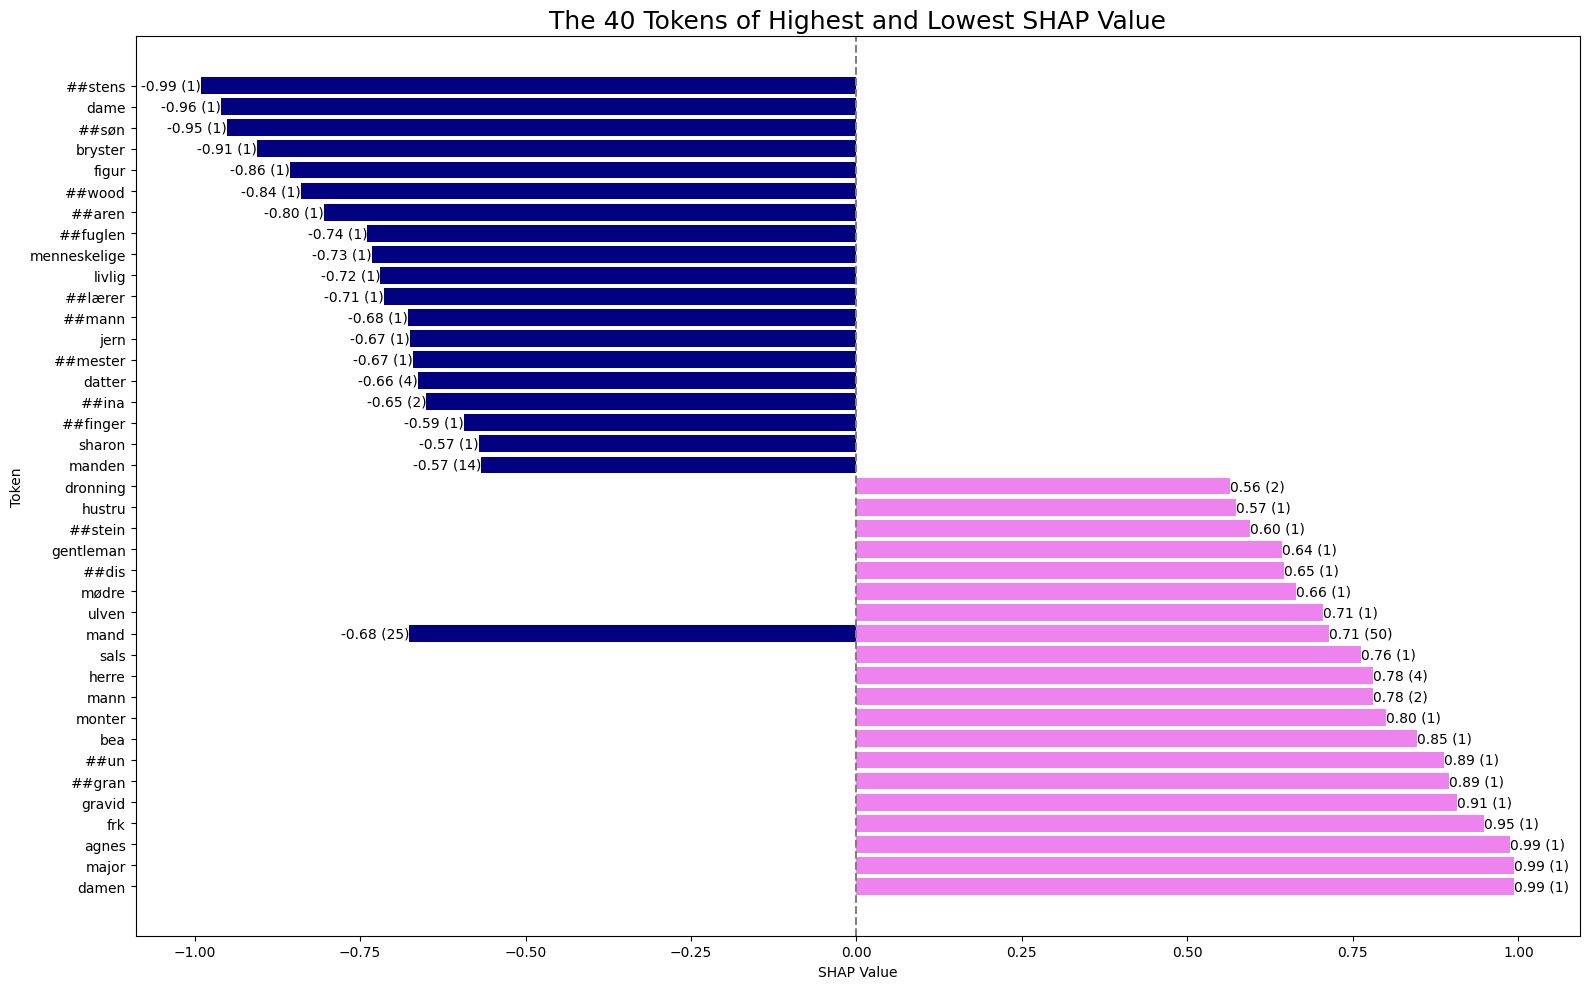

In [ ]:
def addlabels(bars, counts):
    for bar, count in zip(bars, counts):
        label = f'{bar.get_width():.2f} ({count})'
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, label, ha='right' if bar.get_width() < 0 else 'left', va='center')

df_combined = pd.concat([df_top25, df_low25_upside])
tokens = df_combined['token']
values = df_combined['value']
counts = df_combined['n']

plt.figure(figsize=(16, 10))
bars = plt.barh(tokens, values, align='center', color=(df_combined['value'] > 0).map({True: 'violet', False: 'navy'}))

# Call the function to add value labels
addlabels(bars, counts)

plt.axvline(x=0, color='grey', linestyle='--')  # Center line at x = 0
plt.xlabel('SHAP Value')
plt.ylabel('Token')
plt.title('The 40 Tokens of Highest and Lowest SHAP Value',fontsize=18)
plt.tight_layout()  # Adjust layout to fit the label
plt.savefig('/content/drive/MyDrive/Colab_Notebooks/NLP_EX_COLAB/figures/finetuned/all_shaps.png')
plt.show()



### Now for male vs. female predictions
To make this comparison we need to know the index of each text the tokens are coming from. Thus, the download function is slightly altered below:

In [ ]:
import pandas as pd
import json
from pathlib import Path

def load_json_to_dataframe(directory_path):
    # List all .json files in the directory sorted by batch number
    json_files = sorted(Path(directory_path).glob('shap_values_batch_*.json'), key=lambda x: int(x.stem.split('_')[-1]))

    # Creating an empty DataFrame with columns for tokens, values, and text_idx
    df = pd.DataFrame(columns=['token', 'value', 'text_idx'])

    # Initialize a counter for text_idx
    text_idx_counter = 0

    # Function to flatten JSON content and add text index
    def flatten_json(json_content, text_idx_start):
        flattened = []
        for text_idx, sublist in enumerate(json_content, start=text_idx_start):
            for pair in sublist:
                flattened.append((pair[0], pair[1], text_idx))
        return flattened

    # Loop through all .json files and append their content to the DataFrame
    for json_file in json_files:
        # Open and load the json file
        with open(json_file, 'r') as file:
            json_content = json.load(file)

        # Flatten the JSON content and add text index
        flattened_data = flatten_json(json_content, text_idx_counter)

        # Update the text index counter (add the number of texts in the current batch)
        text_idx_counter += len(json_content)

        # Create a DataFrame from the flattened data
        temp_df = pd.DataFrame(flattened_data, columns=['token', 'value', 'text_idx'])

        # Append to the main DataFrame
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

directory_path = '/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/SHAP/shap_outputs'
df_tokens = load_json_to_dataframe(directory_path)



In [52]:
len(df_tokens['text_idx'].unique())

461

##### MATCH CLASSIFICATION REPORT WITH SHAP VALUES:

In [53]:
class_repo = pd.read_csv('/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/eval_outputs/NBL_df_classification_report.csv')
class_repo['text_idx'] = class_repo['Unnamed: 0']
df_merge = pd.merge(df_tokens, class_repo)

### Plotting the token contributions for the prediction
Plotting a few examples of how the word contributes to the classification of a text. 

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_word_importance(df, word_column, value_column, title, title_size, theme, path):
    plt.rcParams['font.family'] = 'Georgia'
    # Normalize the SHAP values to lie between 0 and 1
    min_value, max_value = df[value_column].min(), df[value_column].max()
    norm = Normalize(vmin=min_value, vmax=max_value)
    cmap = theme

    # Calculate the number of lines needed
    num_lines = int(np.ceil(len(df) / 10))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, num_lines * 0.3 + 1.5))  # Extra space for colorbar
    ax.set_axis_off()
    plt.title(title, fontsize=title_size)

    # Display each word with its corresponding color intensity
    for index, (word, value) in enumerate(zip(df[word_column], df[value_column])):
        line_num = index // 10
        x_position = (index % 10) / 10
        y_position = 1 - (line_num + 0.5) / num_lines

        normalized_value = norm(value)
        color = cmap(normalized_value)
        ax.annotate(word, xy=(x_position, y_position), xycoords='axes fraction', color=color,
                    weight='bold', fontsize=12, ha='center', va='center')

    # Create a colorbar for interpretation
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.01, aspect=50, fraction=0.05)
    cbar.set_label('SHAP Value')

    plt.savefig(path)

    # Show the plot
    plt.show()

In [71]:
femal_plot = df_merge[df_merge['Predicted Labels']=='female']
df_male_plt = df_merge[df_merge['Predicted Labels']=='male']

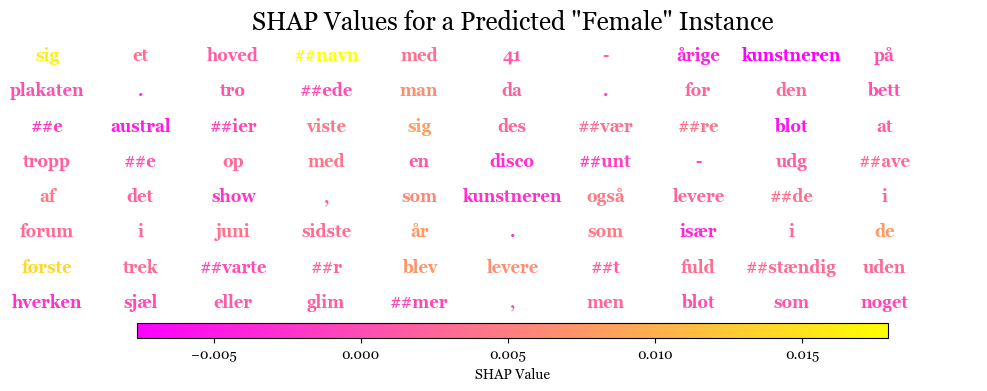

In [72]:
df_444 = femal_plot[femal_plot['text_idx']==444]
path = '/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/figures/finetuned/fem_word_occur.png'
plot_word_importance(df_444[20:100], 'token', 'value', 'SHAP Values for a Predicted "Female" Instance', 18, plt.cm.spring, path)

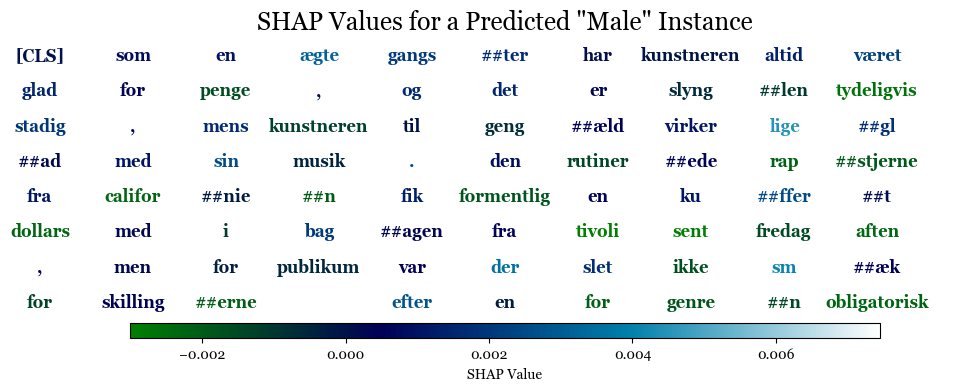

In [73]:
df_431 = df_male_plt[df_male_plt['text_idx']==431]
path = '/Users/laura/Google Drev/Colab_Notebooks/NLP_EX_COLAB/figures/finetuned/male_word_occur.png'
plot_word_importance(df_431[0:80], 'token', 'value', 'SHAP Values for a Predicted "Male" Instance', 18, plt.cm.ocean, path)